In [1]:
import re
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

import seaborn as sns

from scipy.ndimage.filters import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy

In [2]:
agrochemistry_total = pd.read_csv('ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']


agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]
agrochemistry_main['GPS №'] = agrochemistry_main['GPS №'].astype(int)
agrochemistry_main.drop('повторность', axis = 1, inplace= True)
agrochemistry_main.dropna(axis = 0, inplace= True)

agrochemistry_main['Гумус, %'] = agrochemistry_main['Органический углерод, %'] * 1.724
агрохимия_для_статьи = agrochemistry_main[['Тип обработки',"рН солевой вытяжки, ед. рН", "рН водной вытяжки, ед. рН", "Фосфор (подвижная форма), мг/кг", "Калий (подвижная форма), млн-1", "Общий азот, %",'Гумус, %' ]]

In [3]:
агрохимия_для_статьи.groupby('Тип обработки').count()

,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,
ПП,91,91,91,91,91,91
ТТ,54,54,54,54,54,54


In [4]:
агрохимия_для_статьи.groupby('Тип обработки').mean()

,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,
ПП,7.264835,8.247363,15.659544,370.604894,0.174945,2.123431
ТТ,7.232407,8.351852,17.983987,282.253996,0.142593,2.052744


In [5]:
агрохимия_для_статьи.groupby('Тип обработки').std()

,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,
ПП,0.096106,0.186779,11.823894,138.912548,0.035758,0.640059
ТТ,0.191123,0.265039,8.791836,66.989335,0.029472,0.332132


In [31]:
агрохимия_для_статьи.groupby('Тип обработки').std() / агрохимия_для_статьи.groupby('Тип обработки').mean() * 100

,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %","Гумус, %"
Тип обработки,,,,,,
ПП,1.322893,2.264709,75.505989,37.482653,20.439348,30.142675
ТТ,2.642594,3.173414,48.887020,23.733707,20.668967,16.179914


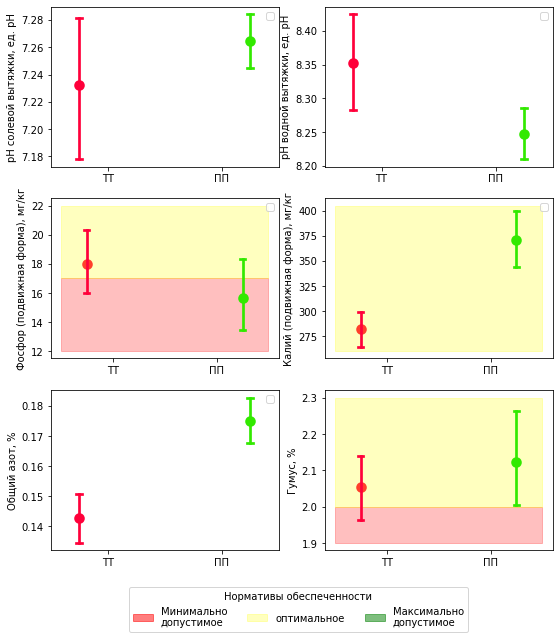

In [7]:
agrochem_prop = [
    "рН солевой вытяжки, ед. рН",
    "рН водной вытяжки, ед. рН", 
    "Фосфор (подвижная форма), мг/кг", 
    "Калий (подвижная форма), млн-1", 
    "Общий азот, %",
    'Гумус, %']
fig, ax  = plt.subplots(3,2, figsize = (9,10))
sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Тип обработки',
    y = "рН солевой вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Тип обработки',
    y = "рН водной вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Тип обработки',
    y = "Фосфор (подвижная форма), мг/кг", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,0])
ax[1,0].fill_between(x = [-0.5,1.5] , y1 = 12,y2 = 17, color='Red', alpha = 0.25)
ax[1,0].fill_between(x = [-0.5,1.5] , y1 = 17,y2 = 22, color='Yellow', alpha = 0.25)
ax[1,0].set_xlabel('')
ax[1,0].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Тип обработки',
    y = "Калий (подвижная форма), млн-1", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,1])
ax[1,1].fill_between(x = [-0.5,1.5] , y1 = 260,y2 = 405, color='Yellow', alpha = 0.25)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('Калий (подвижная форма), мг/кг')

ax[1,1].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Тип обработки',
    y = "Общий азот, %", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,0])
ax[2,0].set_xlabel('')
ax[2,0].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Тип обработки',
    y = 'Гумус, %', 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,1])
ax[2,1].fill_between(x = [-0.5,1.5] , y1 = 1.9,y2 = 2, color='Red', alpha = 0.25)
ax[2,1].fill_between(x = [-0.5,1.5] , y1 = 2,y2 = 2.3, color='Yellow', alpha = 0.25)
ax[2,1].set_xlabel('')
ax[2,1].legend([],[])


a = mpatches.Patch(color="Red", label= 'Минимально\nдопустимое',alpha=0.5)
b = mpatches.Patch(color="Yellow", label= "оптимальное",alpha=0.25)
c = mpatches.Patch(color="Green", label= 'Максимально\nдопустимое',alpha=0.5)

plt.legend(handles=[a,b,c], title='Нормативы обеспеченности',bbox_to_anchor=(0.65,-0.20),ncol = 3)


In [8]:
for ind, prop in enumerate(agrochem_prop):
    sample_list = []
    ab_test = pd.DataFrame()
    for value  in ['ПП','ТТ']:
        sample = агрохимия_для_статьи[агрохимия_для_статьи['Тип обработки'] == value][prop]
        sample_list.append(sample) 
    p_val = ANOVA(*sample_list)[1]
    local_df = pd.DataFrame({"свойство":prop, 'p-value' : p_val}, index = [ind])
    print(local_df)
    ab_test = ab_test.append(local_df)

                     свойство   p-value
0  рН солевой вытяжки, ед. рН  0.176906
                    свойство   p-value
1  рН водной вытяжки, ед. рН  0.006228
                          свойство   p-value
2  Фосфор (подвижная форма), мг/кг  0.212269
                         свойство   p-value
3  Калий (подвижная форма), млн-1  0.000023
        свойство       p-value
4  Общий азот, %  1.008441e-07
   свойство  p-value
5  Гумус, %  0.45275


In [14]:
agrofiz = pd.read_csv("ready_data/агрофизика.csv")

In [20]:
agrofiz = agrofiz[["Тип обработки","Содержание 0,25–10 мм, %", "Содержание 0.25–10 мм(водоустойчивые), % ","СВД, мм","СВД водоустойчивые >10, мм","СВД водоустойчивые 10-7, мм", 'СВД водоустойчивые 7-5, мм',"СВД водоустойчивые 5-3, мм"  ]]

In [22]:
agrofiz.groupby('Тип обработки').count()

,"Содержание 0,25–10 мм, %","Содержание 0.25–10 мм(водоустойчивые), %","СВД, мм","СВД водоустойчивые >10, мм","СВД водоустойчивые 10-7, мм","СВД водоустойчивые 7-5, мм","СВД водоустойчивые 5-3, мм"
Тип обработки,,,,,,,
ПП,9,9,9,9,9,9,9
ТТ,6,6,6,6,6,6,6


In [23]:
agrofiz.groupby('Тип обработки').mean()

,"Содержание 0,25–10 мм, %","Содержание 0.25–10 мм(водоустойчивые), %","СВД, мм","СВД водоустойчивые >10, мм","СВД водоустойчивые 10-7, мм","СВД водоустойчивые 7-5, мм","СВД водоустойчивые 5-3, мм"
Тип обработки,,,,,,,
ПП,0.398852,0.661681,9.106176,5.24834,3.521854,2.071514,1.298840
ТТ,0.452250,0.637208,8.063008,2.75850,1.744740,1.229729,0.906875


In [24]:
agrofiz.groupby('Тип обработки').std()

,"Содержание 0,25–10 мм, %","Содержание 0.25–10 мм(водоустойчивые), %","СВД, мм","СВД водоустойчивые >10, мм","СВД водоустойчивые 10-7, мм","СВД водоустойчивые 7-5, мм","СВД водоустойчивые 5-3, мм"
Тип обработки,,,,,,,
ПП,0.054045,0.081881,0.43421,1.108882,0.862926,0.306476,0.288405
ТТ,0.074064,0.040759,0.90335,0.978510,0.375665,0.223905,0.057123


In [30]:
agrofiz.groupby('Тип обработки').std() / agrofiz.groupby('Тип обработки').mean() * 100

,"Содержание 0,25–10 мм, %","Содержание 0.25–10 мм(водоустойчивые), %","СВД, мм","СВД водоустойчивые >10, мм","СВД водоустойчивые 10-7, мм","СВД водоустойчивые 7-5, мм","СВД водоустойчивые 5-3, мм"
Тип обработки,,,,,,,
ПП,13.550116,12.374654,4.768305,21.128246,24.502042,14.794791,22.204824
ТТ,16.376768,6.396511,11.203631,35.472524,21.531312,18.207677,6.298842


In [25]:
for ind, prop in enumerate(["Содержание 0,25–10 мм, %", "Содержание 0.25–10 мм(водоустойчивые), % ","СВД, мм","СВД водоустойчивые >10, мм","СВД водоустойчивые 10-7, мм", 'СВД водоустойчивые 7-5, мм',"СВД водоустойчивые 5-3, мм"  ]):
    sample_list = []
    ab_test = pd.DataFrame()
    for value  in ['ПП','ТТ']:
        sample = agrofiz[agrofiz['Тип обработки'] == value][prop]
        sample_list.append(sample) 
    p_val = ANOVA(*sample_list)[1]
    local_df = pd.DataFrame({"свойство":prop, 'p-value' : p_val}, index = [ind])
    print(local_df)
    ab_test = ab_test.append(local_df)

                   свойство   p-value
0  Содержание 0,25–10 мм, %  0.129041
                                    свойство   p-value
1  Содержание 0.25–10 мм(водоустойчивые), %   0.512936
  свойство   p-value
2  СВД, мм  0.009876
                     свойство  p-value
3  СВД водоустойчивые >10, мм  0.00065
                      свойство   p-value
4  СВД водоустойчивые 10-7, мм  0.000408
                     свойство   p-value
5  СВД водоустойчивые 7-5, мм  0.000067
                     свойство   p-value
6  СВД водоустойчивые 5-3, мм  0.006358


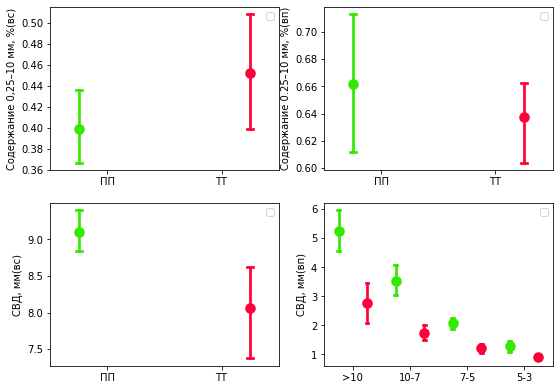

In [44]:
fig, ax  = plt.subplots(2,2, figsize = (9,6.6))
sns.pointplot(
    data = agrofiz,
    x = 'Тип обработки',
    y = "Содержание 0,25–10 мм, %", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Содержание 0,25–10 мм, %(вс)')
ax[0,0].legend([],[])

sns.pointplot(
    data = agrofiz,
    x = 'Тип обработки',
    y = "Содержание 0.25–10 мм(водоустойчивые), % ", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('Содержание 0.25–10 мм, %(вп)')
ax[0,1].legend([],[])

sns.pointplot(
    data = agrofiz,
    x = 'Тип обработки',
    y = "СВД, мм", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,0])
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('СВД, мм(вс)')
ax[1,0].legend([],[])


SVD_by_agregates = agrofiz[[
    'Тип обработки',
    'СВД водоустойчивые >10, мм',
    'СВД водоустойчивые 10-7, мм',
    'СВД водоустойчивые 7-5, мм' ,
    'СВД водоустойчивые 5-3, мм']]
SVD_by_agregates = SVD_by_agregates.melt(
    id_vars = 'Тип обработки' ,
    value_vars = [
        'СВД водоустойчивые >10, мм',
        'СВД водоустойчивые 10-7, мм',
        'СВД водоустойчивые 7-5, мм' ,
        'СВД водоустойчивые 5-3, мм']
    , var_name = 'Агрегаты, мм'
    , value_name='Размер, мм')

SVD_by_agregates['Агрегаты, мм'] = SVD_by_agregates['Агрегаты, мм'].str.split(' ', expand=True)[2].str.replace(',','')

plot = sns.pointplot(data = SVD_by_agregates,
                x = "Агрегаты, мм",
                y = "Размер, мм",
                hue = "Тип обработки",
                palette = "prism",
                scale = 1.2,
                dodge = 0.5,
                ci = 95,
                join = False,
                capsize = .05,
                ax = ax[1,1])
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('СВД, мм(вп)')
ax[1,1].legend([],[])

In [35]:
10/3

3.3333333333333335